## Uncovering Social Media Trends With ETPOL
### COSC-247 Machine Learning: Application Final Project Writeup
### Fynn Hayton-Ruffner

### Overview

Identifying political bias has always been a topic of great fascination for machine learning practicioners. Though this topic spans a wide breadth of distinct application areas, particular attention is paid to bias in news articles (CITE). This is not without good reason; identifying bias is a skill essential to any education that values critical thinking. While the value of article classififcation is undeniable, a gap in the modern literature exists for working with the political ideology of social media posts. In the past, many simpler, though remarkably effective methods were applied to identify the ideology of twitter posts (CITE). These studies used Decision Trees and Support Vector Machines, which, while very effective tools, can only make sense of sequential textual data as a bag of words. THIS STUDY, worked with youtube titles...While this study used transformeres. Though this is at its core an application project, I was interested to see how well the transformer model I created (which I'm calling ETPOL), measured up against these modern benchmarks. I was not expecting to outperform Google's BERT model due to an incomprehensible gap in skill, resources, and time, but I was looking for something in the range of 82 - 90%. The bottom of this range just exceeds the most stellar performances from the standard machine learning models that I could find in less recent, prior research. I was hopeful that ETPOL could beat those models due to the transformer's exceptional ability to handle sequential data, but admittedly a little worried that a dataset on the smaller end of things (~150,000) might hold it back. Nonetheless, 82-90% was my designated range of sucess, which I managed to achieve. I then applied the resulting model to the posts of three subreddits that I thought might be interesting to classify politically: r/climatechange, r/nba, and r/guns. In the following writeup, I begin by describing the data and ETPOL, after which I detail the entire training process and resulting model, followed by its application to the subreddits, and finishing with a discussion of conclusions, implications, and future work.

##### The Data

To start, I had to find a sizeable number of social media posts labeled by political inclination. Luckily, I found two datasets on kaggle that had just the thing: [Messy Twitter Dataset](https://www.kaggle.com/datasets/cascathegreat/politicaltweets) with ~130,000 posts, and [Clean Reddit Dataset](https://www.kaggle.com/datasets/neelgajare/liberals-vs-conservatives-on-reddit-13000-posts/data) with 13,000 posts. However, while I was lucky to find these datasets, they were structured completely differently, so combining them into one took a lot of cleaning and reformatting. I have the full cleaning process in 'clean_data.ipynb' but to sum up, I reformatted the post content of the messy dataset (which was such a pain), removed everything that wasn't alphanumeric or punctuation with regex, renamed columns for consistency, and dealt with invisible unicode chars. When I hopefully use the resulting model on twitter threads, I will have to do apply this same cleaning process to that data for consistency. Nonetheless, after all that, I was able to join the two datasets together to create an 'all_posts.csv' file with 146,478 rows and two columns: 'content' & 'affiliation' (with values left or right); this size is far greater than anything I worked with this semester in this class but it is still relatively small in the grand scheme of ML. For reference, both the polished dataset and the raw csv files are in the 'data' directory of this project.

In [1]:
import pandas as pd
from pathlib import Path

df=pd.read_csv(Path('data/all_posts.csv'))
df.head()

,content,affiliation
0,when you look at the history of big social mov...,left
1,it was great to be back in new jersey! there's...,left
2,"virginians delivered for me twice, and now im ...",left
3,some of the most important changes often start...,left
4,glad i had a chance to talk with our new champ...,left


##### The Tokenizer
After preprocessing the data, the next step in text analysis is to create a tokenizer that maps text to the numerical format necessary to pass it through a transformer. I document the process in 'tokenizer.py' but will summarize it here. To start, I created a word piece tokenizer following the tutorial on [huggingface.com](https://huggingface.co/learn/llm-course/en/chapter6/8). Word piece is a subword tokenizer that breaks words into meaningful sub-units. For example, 'modernization' may become 'modern' & 'ization' since 'ization' may be encountered as a common suffix in the vocabulary. This tackles the common issue of unknown words in new data. Since the tokenizer always starts from every character encountered in the vocab, as long as the input text doesn't have any new characters it will be able to handle it. Given the size of the dataset and that I formatted the input data to only include alphanumeric chars and punctuation, it is very unlikely for the tokenizer to encounter characters not already in its vocabularly. After training the tokenizer on my dataset in tokenizer.py, I its state in the 'wp_tokenizer' directory. It has a 20,000 token vocabulary, which was more than enough to account at least for all the unique characters in my dataset. I provide an example below of how the tokenizer encodes a string into its numerical representation and back again. You'll notice if you run it that not only is the decoded text string normalized (to lower case and uniform whitespace separation), but a new [CLS] token appears at the front. It is standard practice in text classification tasks to include this special CLS token as the token from which the class probabilities of the entire text are extracted (CITE BERT).

In [2]:
from transformers import PreTrainedTokenizerFast
from pathlib import Path 

test_str = "I am a test string!"
tokenizer = PreTrainedTokenizerFast.from_pretrained(Path('wp_tokenizer'), model_max_length=25)

tokenized = tokenizer.encode(test_str)
print(f'Tokens: {tokenized}')
print(f'Decoded tokens: {tokenizer.decode(tokenized)}')

Tokens: [2, 33, 157, 25, 1530, 19216, 3]
Decoded tokens: [CLS] i am a test string !


##### ETPOL
As mentioned above, I decided to try to code my own encoder model using the pytorch module, since transformers tend to outperform other machine learning model on text related tasks. The reason for this gap is attention, the key process of a transformer that enriches the meaning of every token by the context that surrounds it (kind of like how we interpret text). To create the model, I followed pure encoder structure laid out by [Attention is All You Need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). Below I detail the flow of any input sequence of text through the model (writing this out always helps me better understand what this does). I set the max context length of ETPOL to a reasonable 512 tokens, so to make things simpler, anything longer gets truncated and anything shorter gets padded.

Input X shape: (512) -> 512 tokens in input sequence

1: Embedding layer (20,000 x d_model matrix): holds the embedding vector (of size d_model) of every token in the vocabulary (20,000 total). The embedding is meant to encode the meaning of every token numerically. It is the values within each embedding vector that are updated by the encoder with the idea that, by the end of the process, the output embedding of each token comes to represent the reality of what that token means within the context of the sequence. Each input token passes through this layer by indexing its corresponding row in the matrix, and thus every token is transformed into its corresponding embedding vector.

X shape: (512 x d_model): now every token is represented by an embedding vector of dimension d_model

2: Positional Encoder: The positional encoder is a 512 x d_model matrix that, in each row, holds an embedding for every possible position in the input sequence. For example, the token in the 5th position in input sequence has the embedding of the 5th row of this matrix added to it. This process happens for every token embedding in the input

X shape: (512 x d_model): the same shape, but each token embedding has been encoded with positional information

3: Encoder block:
First step: Attention:
    Attention begins by transforming any input token into 3 distinct embeddings via weight matrices: 
        1) the query: the vector represenation of an input embedding as the current token being processed in the sequence
        2) the key: the vector representation of an input embedding as a preceding token in the sequence
        3) the value: the actual value representaiton of a preceding token - used to update the current token after being scaled by its similarity (see below)
    For every input token i, the following process takes place for all preceding tokens j:
        The 'similarity' between i as a query vector and j as a key vector is computed by scaled dot product (which divides by the shape of the key vector). This similarity score is normalized with softmax and serves as scaler for value vector of j. The intuition is that the more similar the two tokens are, the more influence the j value vector will have on the encoded ouput of i. Thus, every preceding token is weighted by its similarity to the current token, and these products are summed up to produce an output vector which is then added back to the initial input embedding of token i. Theoretically, i now contains a more richer reprsentation of that tokens meaning by attending to its context.
    MULTI-HEAD ATTENTION: In practice, the attention process described above is divided among multiple heads, each of which handle different sections of any input embedding. The idea here is that each head learns to be responsible for different linguistic patterns between the token and the context. The query, key, and value vectors for every token in each head are shape d_model/num_heads, and the resulting attention output from each head for any token i is concatenated together prior to updating the input embedding of i.

X shape: (512 x d_model): the same shape, but each token embedding has been updated significantly by the attention output
Next: FeedForward MLP
    After attention, the other core component of an encoder block is the feedforward neural net. The input layer is transformed into a higher dimension (d_hidden), flows through the hidden layers that apply the ReLU activation function to weighted sum of each node (at least that's what I did), whose ouput is transposed back to the same shape as the input. Neural networks excel at discovering non linear relationships between inputs; the encoder takes advantage of that here. The output of the neural net is again shape 512 x d_model, holding new embedding representations from each token. These values are added to the attention updated embeddings.

* I'm leaving out layer normalization and dropout, but note that I did apply those methods in each encoder block
The input passes through an arbitrary number of these encoder blocks, the idea being that by the end of the stack, their embeddings hold rich contextual and linguistic information that will result in better performance on the task at hand

X shape: (512 x d_model): the same shape, but each token embedding has been updated significantly by the attention output, and feedforward.


4: Linear output: after being passed through the linear output, I extract the [CLS] token, which is inserted at the beginning of every input sequence. This token is meant to contain the label for classfication tasks after sufficient training, and is a common method for classfication in transformers. The embedding of the token is reduced from shape d_model to shape 2 (for two classes) by a linear layer. The two values here are meant to hold the class probabilites of the input sentence.

X shape (2): just raw logit probs for each class

Below is an example pass through the model using a random observation in the dataset.

In [3]:
import torch
import torch.nn as nn
from transformers import PreTrainedTokenizerFast
from models import ETPOL
from pathlib import Path
from PostsDataset import PostsDataset

context_length = 512
d_model = 512

model = ETPOL(
    vocab_size=20000,
    context_length=context_length,
    d_model=d_model,
    num_heads=8,
    num_hidden_layers=2,
    d_hidden=2048,
    num_encoders=8,
    pdrop=0.5
)

tokenizer = PreTrainedTokenizerFast.from_pretrained(Path('wp_tokenizer'), model_max_length=context_length)
# creates a dataset object from the dataframe, which internally handles tokenizing the inputs
dataset = PostsDataset(df, tokenizer, context_length)
rand_example = dataset.__getitem__(3)


In [4]:
reverse_label_map = {1: 'left', 0: 'right'} # this is the scheme I used to encode labels
inputs = rand_example['input_ids'].unsqueeze(0) # add the batch dimension (expected by model, used to speed up training)
print(inputs)
label = rand_example['labels']
outputs = model(inputs)
print(outputs)
print(outputs.shape) # class probs, one for each class, first dimension is batch size

tensor([[    2,   719,   113,    90,   798,   832,  4055,  2876,  1018,   107,
           565,  9804,    11,   159,     6,    43,   658,    33,     6,    37,
           473,    96,   364,   480,  6505,   119,    90,  2861,   565,  7119,
            11,    33,  1337,   160,     6,  1577,   398,   289,   109,    90,
            28, 12647,    59,   107,  2651,   503,   370,   874,    11,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,  

In [5]:
# lets look at the result! this is an untrained model so there is no significance to its prediction, especially given the binary nature of the classification
print(f"input post was: {tokenizer.decode(rand_example['input_ids'])}")
print(f"its label was: {reverse_label_map[int(label)]}")
print(f"It was predicted to be: {reverse_label_map[int(torch.argmax(outputs, dim=-1))]}")

input post was: [CLS] some of the most important changes often start in state legislatures . that ' s why i ' m proud to support these candidates for the virginia state legislature . i hope you ' ll join me and the d ##lc ##c in giving them your vote . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

##### TRAINING & HYPERPARAMETER TUNING

I've now stepped through data preprocessing, creating the tokenizer, and the model structure. In the description of ETPOL above, I mention a lot of components (number of heads, number of encoder blocks, dimension of embeddings, hidden layers, dimension of hidden layers etc.) To be clear, I did not know beforehand what the best configuration of these model hyperparameters would be (how would I?), so I left that up to training. There was also the question of learning rate, batch size, and dropout rate (for regularization). After testing my training loop code in main.py, which trains one model with a given set of parameters and saves its by-epoch results with model state, I set up an optimization script using the [Optuna Library](https://optuna.org/). Before I go over that however, I want to make sure to briefly describe the training methods (available in test_utils.py). I used the AdamW optimizer, a more advanced version of SGD, and the Cross Entropy loss function, which is useful for binary or multi-classification tasks. I split the dataset into 70% train, 15% validation, and 15 % test, and wrapped dataloader objects around each (this object shuffles and batches observations into a format compatable with the model & allows for more efficient training). For every epoch of the training loop, each batch of training data was used to calculate loss and update the weights of the model via backpropogation (see train function in test_utils.py). At the end of each epoch, model performance on the training and validation sets was evaluated via accuracy, average loss, precision, recall, f1 (see evaluate_model in test_utils.py). Finally, at the end of training, I could evaluate each model on the test set. 

We spent a fair amount of time in class talking about hyperparameter tuning, so I wanted to make sure I incorporated that into the project. However, since I wasn't directly using a sklearn model, I decided to look into other methods. Optuna is a library with a super friendly user interface that allows you to create study objects. These objects take in an objective function (see objective in opt.py) that can either be minimized or maximized. It allows you to define a search space for any number of parameters (see the calls to 'suggest' within the objective function in opt.py) and a number of trials to conduct. For each trial you set the metric to be optimized (I chose validation accuracy) and, TRY TO EXPLAIN BAYESIAN OPTIMIZATION. Within each trial, I initialized ETPOL with the suggested model paramters, and trained it for 6 epochs (with early stopping if val loss increased twice in a row) with set of chosen hyperparameters. Since my training loop returns results, all I had to do was extract the validation accuracy and let Optuna do its thing. I tried to explain what I was doing best I could in these files through comments, so looking through the scripts can provide more detail. I ran an optuna with 20 trials and the best model had a validation accuracy of ~83%. Afterwards, I used the hyperparameters for that best performing model and ran it through the training script of main.py one last time, allowing me to save that model state to use at a later stage for analyzing new tweet threads.
* Due to the size of my dataset and model all training and optimization scripts were run on the a100 FrostByte GPU. This is why I have the main.sb and opt.sb slurm scripts in the project directory.

#### Training Results

As I mentioned above, I used the optuna library to try to find superior hyperparameters to enhance model performanc, particularly on accuracy. However, before doing that I ran 6 test runs training ETPOL with relatively random configurations. The csv files that hold the results of these trials are available in the results folder, but you can run the code cell below to see each trial's performance on validation loss, accuracy, precision, recall, and f1 (again I was most concerned with accuracy). The specifics of the hyperparameters for each test run are in the 'results' folder as well. For example, test_1_metrics.csv holds the by-epoch performance of the test_1 model configuration on training, val, and test sets while test_1_params is a test file denoting the parameter configuration for that run.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


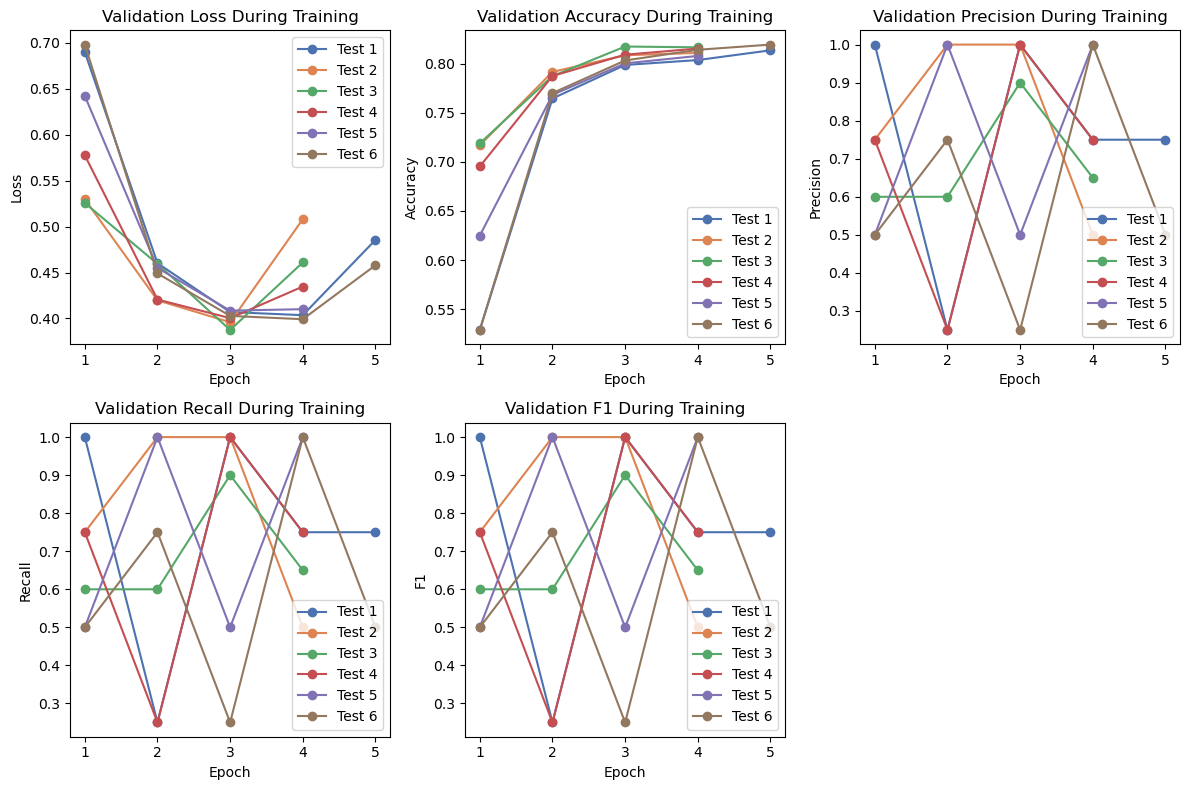

In [6]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

df = pd.read_csv('./results/all_train_results.csv')

metrics = df['metric'].unique()
models = df['model'].unique()
pal = sns.color_palette('deep', len(models))

model_color_dict = {}
for mod, color in zip(models, pal):
    model_color_dict[mod] = color
 
# Filter to validation data
df = df[df['set'] == 'val']
metrics = df['metric'].unique()

# Create subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axs = axs.flatten()  # flatten to 1D array of Axes

for i, met in enumerate(metrics):
    if i >= len(axs):
        break
    ax = axs[i]
    
    for model in models:
        subset = df[(df['metric'] == met) & (df['model'] == model)] 
        ax.plot(subset['epoch'], subset['score'], marker='o', linestyle='-',
                c=model_color_dict[model], label=model)
    
    ax.set_title(f'Validation {met.capitalize()} During Training')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(met.capitalize())
    ax.legend()
axs[5].set_visible(False)
    
plt.tight_layout()
plt.show()

I was pretty happy to achieve a validation accuracy capping off at ~82%. You'll notice that some of the trials didn't get to all 5 epochs, this is because I implemented early stopping if the validation loss increased (for efficiency's sake). These trials took an average of ~5 hours with an upper end of 9 for more complex models and 2 for lighter weight models. For reference, the best validation accuracy from these random trials, as demonstrated below, was model 6 with a val accuracy of 0.8196

In [7]:
df = df[(df['set'] == 'val') & (df['metric'] == 'accuracy')]
df.loc[df['score'].idxmax()]

epoch          5.0
set            val
metric    accuracy
score     0.819634
model       Test 6
Name: 282, dtype: object

As I mentioned before though, I wanted to 

### Annotating the subreddit data & RESULTS

In annotate.py, I annotate the posts obtained from the r/climatechange, r/nba, and r/guns subreddits that I scraped (using R) and cleaned in the 'scrape' directory. The full post dataset is in './scrape/subreddits_cleaned.csv' and the subsequent annotated version is in './annotated_subreddits/posts_w_pol.csv'. All I did to annotate was feed the content of each post into ETPOL and have it classify the post as leaning right or left. Down below I compare the subreddits based on their political leanings (at least what ETPOL thinks).

In [ ]:
posts = pd.read_csv('./annotated_subreddit/posts_w_pol.csv')

subs = {'climatechange', 'nba', 'guns','democrats', 'Republican', 'saturdaynightlive', 'abortion'}
posts.groupby('subreddit')['affiliation'].value_counts()




subreddit          affiliation
Republican         right          540
                   left           394
abortion           left           167
                   right          132
climatechange      left           468
                   right          461
democrats          right          517
                   left           459
guns               right          517
                   left           470
nba                right          504
                   left           425
saturdaynightlive  right          531
                   left           460
Name: count, dtype: int64

The Republican subreddit is dominated by right-wing influenced posters (540-394)-no surprise there. Abortion is more even (167 left vs 132 right). Climate change is quite even at (468 left to 461 right). Most surprisingly, the r/democrats subreddit has significantly more right wing posts (517) than left (459). Guns is less shocking (517 right vs 470 left), the second amendment will always inspire more passion in the right. The r/nba subreddit is interesting, leaning towards the right (504 - 425). I have always though of the NBA as a progressive organization, but the posters on its subreddit may not be representative of that. I think back to the pandemic when NBA athletes wore BLM shirts, the sheer level of conservative uproar was staggering, so considering that, this conservative majority is not entirely imposisble. Finally, SNL is also more populated by right wing posts (531 to 460). I think this could also be for a reason similar to that for the NBA. While SNL is a progressive show, those most vocal about it tend to be critical and, also tend to be conservative.

### Conclusions, Implications, & Limitations

### Future Work

### References